# Testing `Whirl2d` on Navier-Stokes solution with a body 

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes, Process);

### Create a body

#### Create a cylinder

In [2]:
bcyl = let Npts = 100,  # total number of points on circle
            rad = 0.5,   # radius of circle
            xcent = [0.0,0.0],  # initial centroid of circle
            ang = 0.0    # initial angle of circle
   Bodies.Circle(Npts,rad,xcent,ang)
end

Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807


#### Or create a plate

In [354]:
bplate = let Npts = 100,  # number of points on each flat side of plate
        len = 1.0,   # length of the plate
        thick = 0.023, # thickness
        λ = thick/len,  # a parameter that controls the ratio of spacing of points on plate
        xcent = [0.0,0.0], # initial centroid of the body
        ang = -π/4  # initial orientation of the body
        Bodies.Plate(Npts,len,thick,λ,xcent,ang)
end

Body: number of points = 364, reference point = (0.0,0.0), rotation matrix = [0.707107 0.707107; -0.707107 0.707107]
     max spacing between points = 0.01568667143291011
     min spacing between points = 0.0004387201713045025


### Create a domain with this body in it

In [3]:
dom = let xmin = [-1.0,-1.0], # minimum dimensions of domain
          xmax = [3.0,1.0]   # maximum dimensions of domain
        Systems.DualDomain(xmin,xmax)
end

# Add the body to the domain
dom = Systems.add_body(dom,bcyl)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [4]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 1
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]
     max spacing between points = 0.03141075907812899
     min spacing between points = 0.03141075907812807

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [5]:
Re = 200
physparams = let U = [1.0,0.0]
    NavierStokes.set_freestream(U)
end
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)
tparams

Time step size 0.01

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [6]:
gops, ops = NavierStokes.set_operators_body!(dom,params);

Setting up LGF table
  0.384719 seconds (276.35 k allocations: 305.907 MiB, 10.20% gc time)
Setting up integrating factor table
  0.003928 seconds (2.18 k allocations: 1.916 MiB)
Setting up body-to-grid operator


Computing Eᵀ... 16%|██████                              |  ETA: 0:00:05

  3.030250 seconds (559.06 k allocations: 497.546 MiB, 2.69% gc time)
Computing Schur complements and inverses
 

Computing Eᵀ...100%|████████████████████████████████████| Time: 0:00:02


 2.338524 seconds (482.75 k allocations: 185.480 MiB, 1.51% gc time)
  0.821983 seconds (12.18 k allocations: 128.918 MiB, 3.06% gc time)


### Create an initial solution structure

In [7]:
s = NavierStokes.BodySoln(dom)
h = [s]

1-element Array{Whirl2d.ConstrainedSoln{Array{Float64,2},Array{Float64,2}},1}:
 Solution: t = 0.0


In [8]:
using BenchmarkTools

In [10]:
@benchmark TimeMarching.ifherk!($s,$tparams,$ops)

BenchmarkTools.Trial: 
  memory estimate:  22.93 MiB
  allocs estimate:  16080
  --------------
  minimum time:     62.618 ms (4.56% GC)
  median time:      64.468 ms (4.63% GC)
  mean time:        64.622 ms (4.81% GC)
  maximum time:     68.300 ms (4.63% GC)
  --------------
  samples:          78
  evals/sample:     1

In [18]:
@benchmark ops.r₁($s,$s.t)

BenchmarkTools.Trial: 
  memory estimate:  5.29 MiB
  allocs estimate:  130
  --------------
  minimum time:     5.583 ms (0.00% GC)
  median time:      6.821 ms (0.00% GC)
  mean time:        7.304 ms (9.77% GC)
  maximum time:     11.744 ms (36.07% GC)
  --------------
  samples:          684
  evals/sample:     1

In [13]:
@benchmark ops.A⁻¹(ops.r₁($s,$s.t))

BenchmarkTools.Trial: 
  memory estimate:  5.45 MiB
  allocs estimate:  138
  --------------
  minimum time:     9.071 ms (0.00% GC)
  median time:      10.181 ms (0.00% GC)
  mean time:        10.693 ms (6.16% GC)
  maximum time:     14.166 ms (21.52% GC)
  --------------
  samples:          467
  evals/sample:     1

In [14]:
@benchmark ops.B₂($s.u)

BenchmarkTools.Trial: 
  memory estimate:  166.70 KiB
  allocs estimate:  14
  --------------
  minimum time:     3.331 ms (0.00% GC)
  median time:      3.504 ms (0.00% GC)
  mean time:        3.662 ms (0.64% GC)
  maximum time:     9.028 ms (0.00% GC)
  --------------
  samples:          1362
  evals/sample:     1

In [16]:
@benchmark ops.S⁻¹(ops.B₂($s.u) - ops.r₂($s,$s.t))

BenchmarkTools.Trial: 
  memory estimate:  335.55 KiB
  allocs estimate:  4530
  --------------
  minimum time:     4.284 ms (0.00% GC)
  median time:      4.459 ms (0.00% GC)
  mean time:        4.603 ms (1.28% GC)
  maximum time:     10.792 ms (56.54% GC)
  --------------
  samples:          1085
  evals/sample:     1

In [17]:
@benchmark ops.A⁻¹(ops.B₁ᵀ($s.f))

BenchmarkTools.Trial: 
  memory estimate:  646.44 KiB
  allocs estimate:  20
  --------------
  minimum time:     3.376 ms (0.00% GC)
  median time:      3.740 ms (0.00% GC)
  mean time:        3.891 ms (2.23% GC)
  maximum time:     8.157 ms (44.85% GC)
  --------------
  samples:          1283
  evals/sample:     1

### Advance the solution

In [207]:
@time for i = 1:200
    s = TimeMarching.ifherk!(s,tparams,ops)
    push!(h,s)
end
s

 15.501284 seconds (4.18 M allocations: 4.516 GiB, 7.10% gc time)


Solution: t = 2.0000000000000013


### Evaluate the fields in the solution history

In [363]:
@time f = NavierStokes.evaluateFields.(h,dom.grid,gops);
t = map(x -> x.t, f);
ω = map(x -> x.ω, f);
ψ = map(x -> x.ψ, f);
ux = map(x -> x.ux, f);
uy = map(x -> x.uy, f);

  1.459058 seconds (90.06 k allocations: 440.105 MiB, 24.87% gc time)


### Evaluate and plot the force history

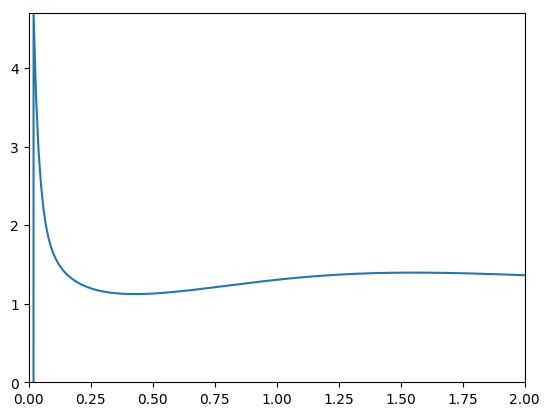

(0, 2.0000000000000013)

In [364]:
tforce, fx, fy = NavierStokes.force(h,dom.grid);
plot(tforce,2*fx)
ylim(0,maximum(2*fx))
xlim(0,tforce[end])

### Sample the solution at some point

In [12]:
spts = Process.SamplePoint(1.5,1.5)

Whirl2d.Process.SamplePoints([1.5], [1.5])

In [13]:
x = Grids.xfacex(dom.grid)
y = Grids.yfacex(dom.grid)
uxsamp = Process.sample(spts,ux,x,y)

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0144011, 0.0147398, 0.0150096, 0.0152371, 0.0154388, 0.0156248, 0.0158013, 0.0159724, 0.0161409  …  0.0987671, 0.0992734, 0.0997759, 0.100274, 0.100769, 0.10126, 0.101746, 0.102228, 0.102706, 0.103179]

In [ ]:
size(x)

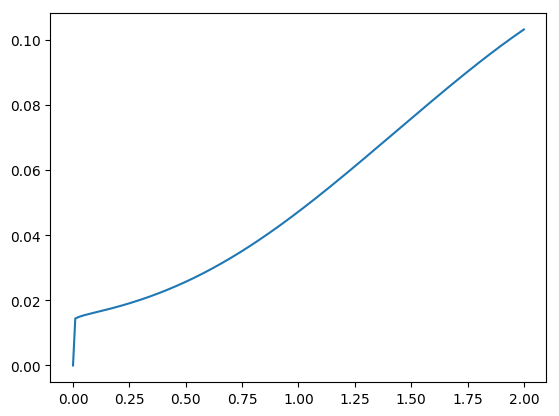

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x12f6d2050>

In [14]:
plot(t,uxsamp[1])

### Plot the fields

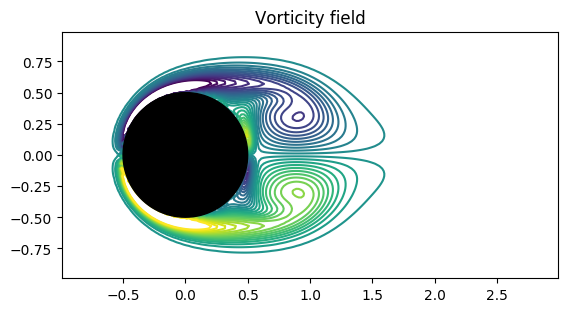

PyObject <matplotlib.text.Text object at 0x1f4d6cb50>

In [365]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)

contour(x,y,transpose(ω[end]),linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Vorticity field")

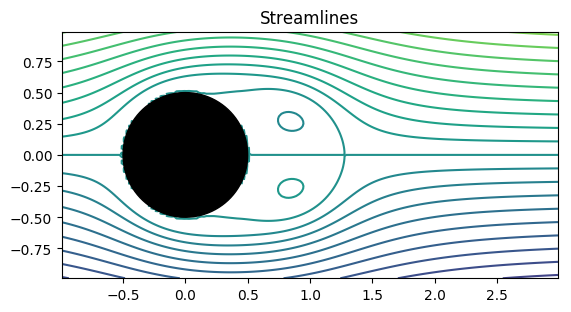

PyObject <matplotlib.text.Text object at 0x13027c250>

In [16]:
x = Grids.xcell(dom.grid)
y = Grids.ycell(dom.grid)
contour(x,y,y.+transpose(ψ[end]),linspace(-1.5,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamlines")

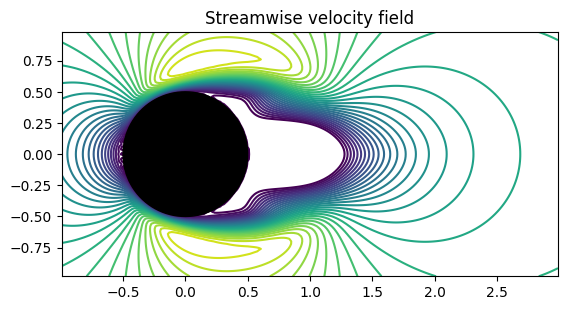

PyObject <matplotlib.text.Text object at 0x1305d9c10>

In [17]:
contour(Grids.xfacex(dom.grid),Grids.yfacex(dom.grid),transpose(ux[end]).+1,linspace(0,1.5,31))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k",zorder=2)
end
axis("scaled")
title("Streamwise velocity field")

In [249]:
teval = 0.05
ux,uy = Grids.curl(dom.grid,-gops.L⁻¹(h(teval).u))
vx,vy = Grids.shift(dom.grid,Grids.curl(dom.grid,-gops.L⁻¹(h(teval).u))) # vx is x velocity at dual x faces, 
wx,wy = Grids.shift(dom.grid,h(teval).u) # wx is w at the dual x faces, wy is w at the dual y faces
f̃ = h(teval).f
fx,fy = reshape(dom.Eᵀ[1]*f̃[:,1],size(dom.grid.facex)),reshape(dom.Eᵀ[2]*f̃[:,2],size(dom.grid.facey))
divwxu = Grids.diverg(dom.grid,-vy.*wy+fx,(vx.+1.0).*wx+fy);
divwxu = [zeros(1,dom.grid.N[2]+2); zeros(dom.grid.N[1]+1,1) divwxu];
#divwxu = [divwxu zeros(dom.grid.N[1]+1,1); zeros(1,dom.grid.N[2]+2)];
ptot = -gops.L⁻¹(divwxu./dom.grid.Δx)*dom.grid.Δx^2
ptot = ptot[1:dom.grid.N[1]+1,1:dom.grid.N[2]+1]
vxnode = 0.5*(ux[1:dom.grid.N[1]+1,:]+ux[2:dom.grid.N[1]+2,:]) + 1.0;
vynode = 0.5*(uy[:,1:dom.grid.N[2]+1]+uy[:,2:dom.grid.N[2]+2]);
p = ptot - 0.5*(vxnode.^2+vynode.^2);
psurf = dom.Ẽᵀ[2]'*reshape(p,length(dom.grid.node));
p = p[2:dom.grid.N[1],2:dom.grid.N[2]];

norms = [map(x -> x[1], Bodies.normal(dom.body[1])) map(x -> x[2], Bodies.normal(dom.body[1]))]
#tract = h(0.5).f*dom.grid.Δx^2./Bodies.ds(dom.body[1])
#press = -sum(tract.*norms,2);
ds = Bodies.ds(dom.body[1]);
ssurf = cumsum([0; 0.5*(ds[1:dom.body[1].N-1]+ds[2:dom.body[1].N])]);

In [242]:
mean(psurf)

-0.08365270350928121

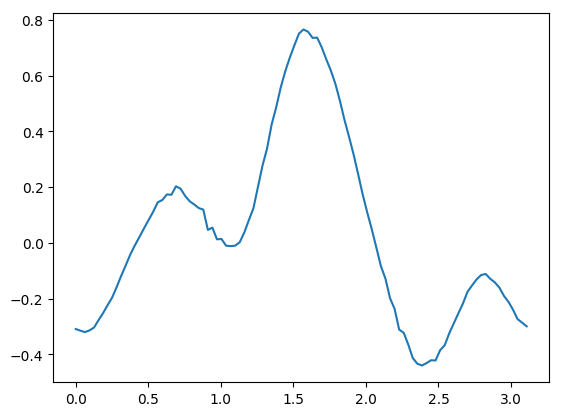

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14ae1d150>

In [250]:
plot(ssurf,psurf+0.03)

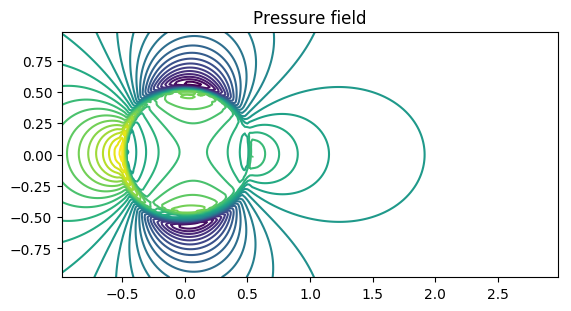

PyObject <matplotlib.text.Text object at 0x14b592c10>

In [253]:
xnode = Grids.xnode(dom.grid)
ynode = Grids.ynode(dom.grid)

contour(xnode,ynode,transpose(p),31)
#for j = 1:dom.nbody
#    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
#    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
#    fill(xpt,ypt,color="k",zorder=2)
#end
axis("scaled")
title("Pressure field")